In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
from torch import distributions, optim

In [3]:
import pickle
%cd ..

with open('data/modeling/factors_info.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    factors_info = pickle.load(f)

/home/anuarsantoyo/PycharmProjects/master-thesis


# Losses comparison

In [4]:
df_new = pd.DataFrame(columns=['factor', 'meta_epoch','day', 'loss'])
for factor in factors_info.keys():
    for meta_epoch in factors_info[factor]['loss_development'].keys():
        losses = list(factors_info[factor]['loss_development'][meta_epoch])
        df_dict = {'factor':[factor]*len(losses), 'meta_epoch': [meta_epoch]*len(losses),'day': list(range(len(losses))), 'loss': losses}
        df_old = pd.DataFrame(df_dict)
        df_new = pd.concat([df_new, df_old], ignore_index=True)

In [5]:
df_new.replace({"['F1_perception_advice', 'F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']": 'all'}, inplace=True)

Text(0.5, 1.0, 'Losses development')

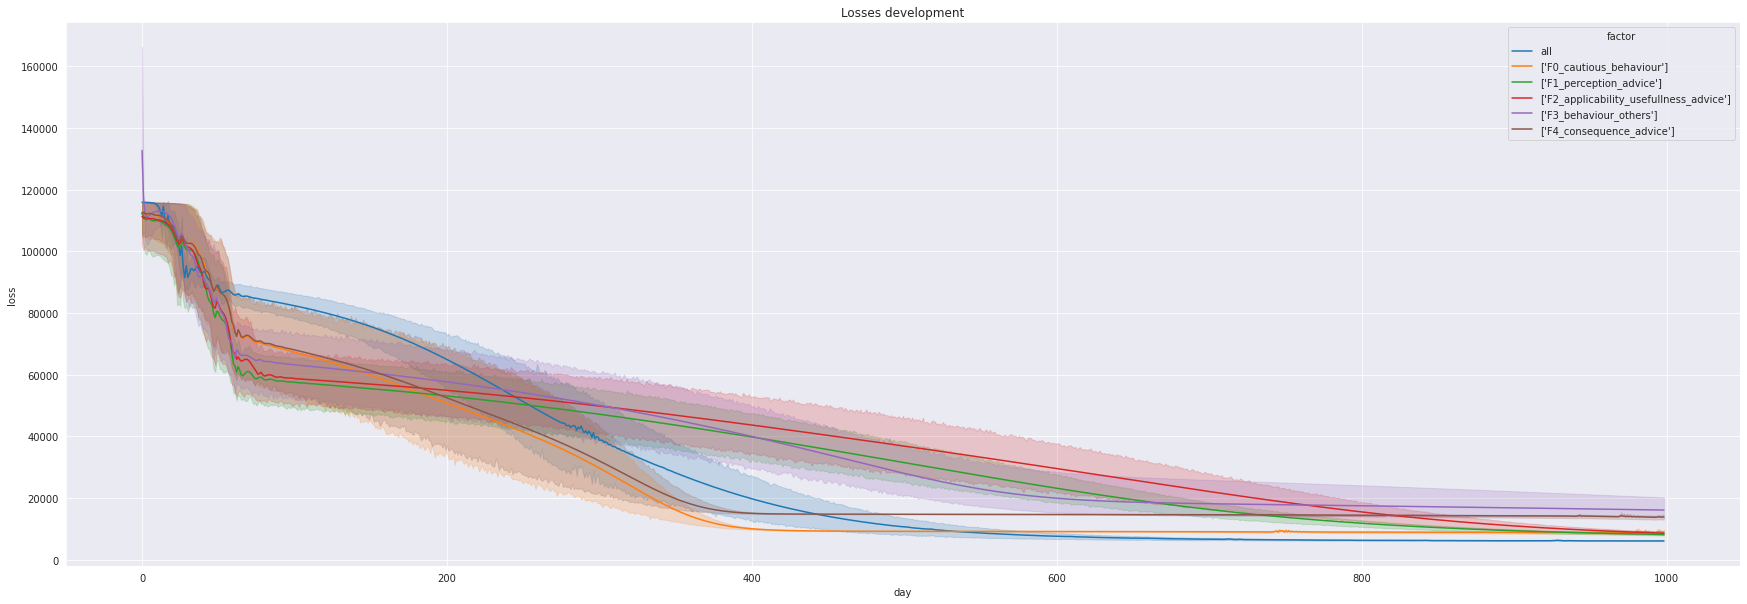

In [6]:
plt.figure(figsize=(30,10))
sns.lineplot(data=df_new, x="day", y="loss", hue="factor")
plt.title('Losses development')
#plt.savefig('../data/modeling/losses_development.png')

# Prediction Comparison

In [7]:
df_new = pd.DataFrame(columns=['factor', 'meta_epoch','day', 'hospitalized'])
for factor in factors_info.keys():
    for meta_epoch in factors_info[factor]['meta_epoch_pred_test'].keys():
        hospitalized = list(factors_info[factor]['meta_epoch_pred_test'][meta_epoch])
        df_dict = {'factor':[factor]*len(hospitalized), 'meta_epoch': [meta_epoch]*len(hospitalized),'day': list(range(len(hospitalized))), 'hospitalized': hospitalized}
        df_old = pd.DataFrame(df_dict)
        df_new = pd.concat([df_new, df_old], ignore_index=True)

In [8]:
df_new.replace({"['F1_perception_advice', 'F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']": 'all'}, inplace=True)


In [9]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *
from clustering.utils import *
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01'
test_end_time='2021-02-01' # Begin Vaccination Wave
observation = 'hospitalization'
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
rolling_avg_obs = 1
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.0,64.0,4.0
1,2020-08-02,0.0,78.0,2.0
2,2020-08-03,0.0,117.0,7.0


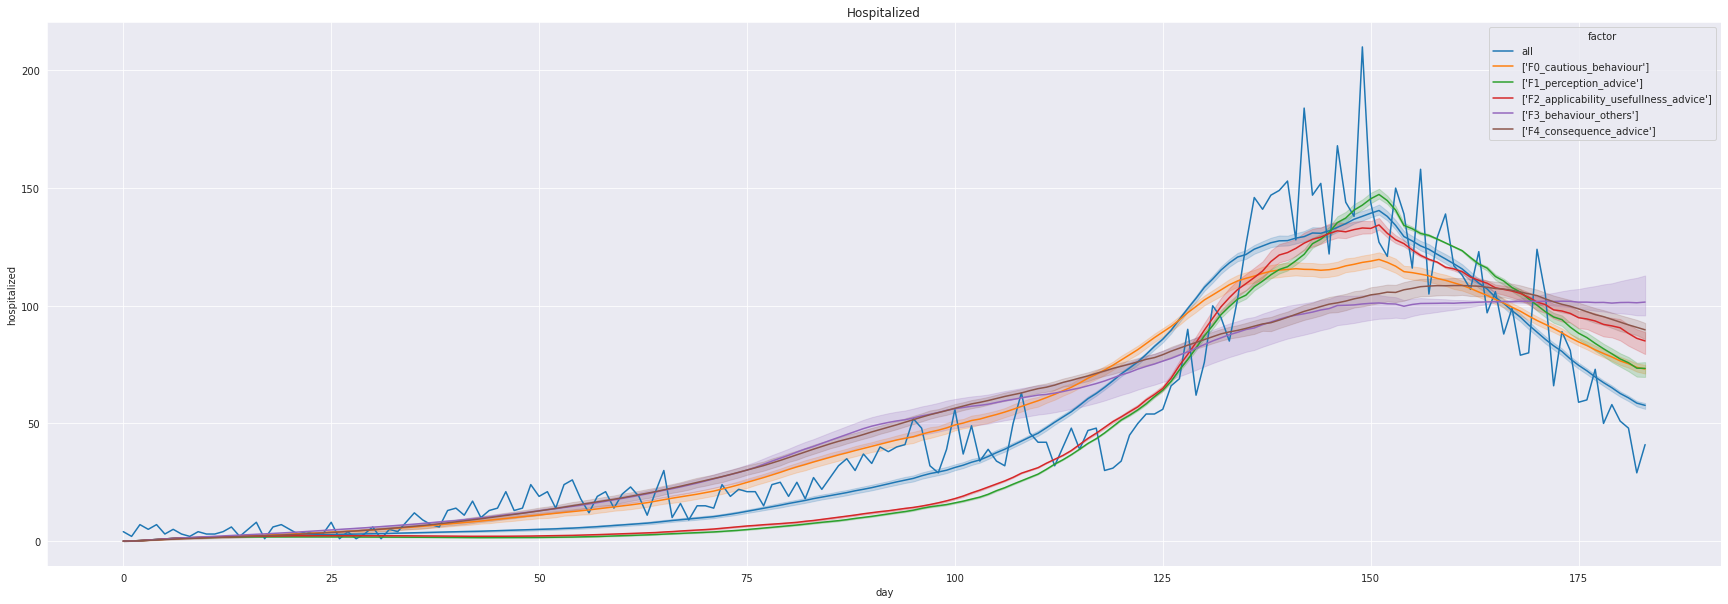

In [10]:
#plt.figure(figsize=(15,15))
plt.figure(figsize=(30,10))
plt.plot(observed_train.detach().numpy())
sns.lineplot(data=df_new, x="day", y="hospitalized", hue="factor")
plt.title('Hospitalized')
plt.show()
#plt.savefig('data/modeling/predictions_factor_comparison.png')

# Parameter comparison

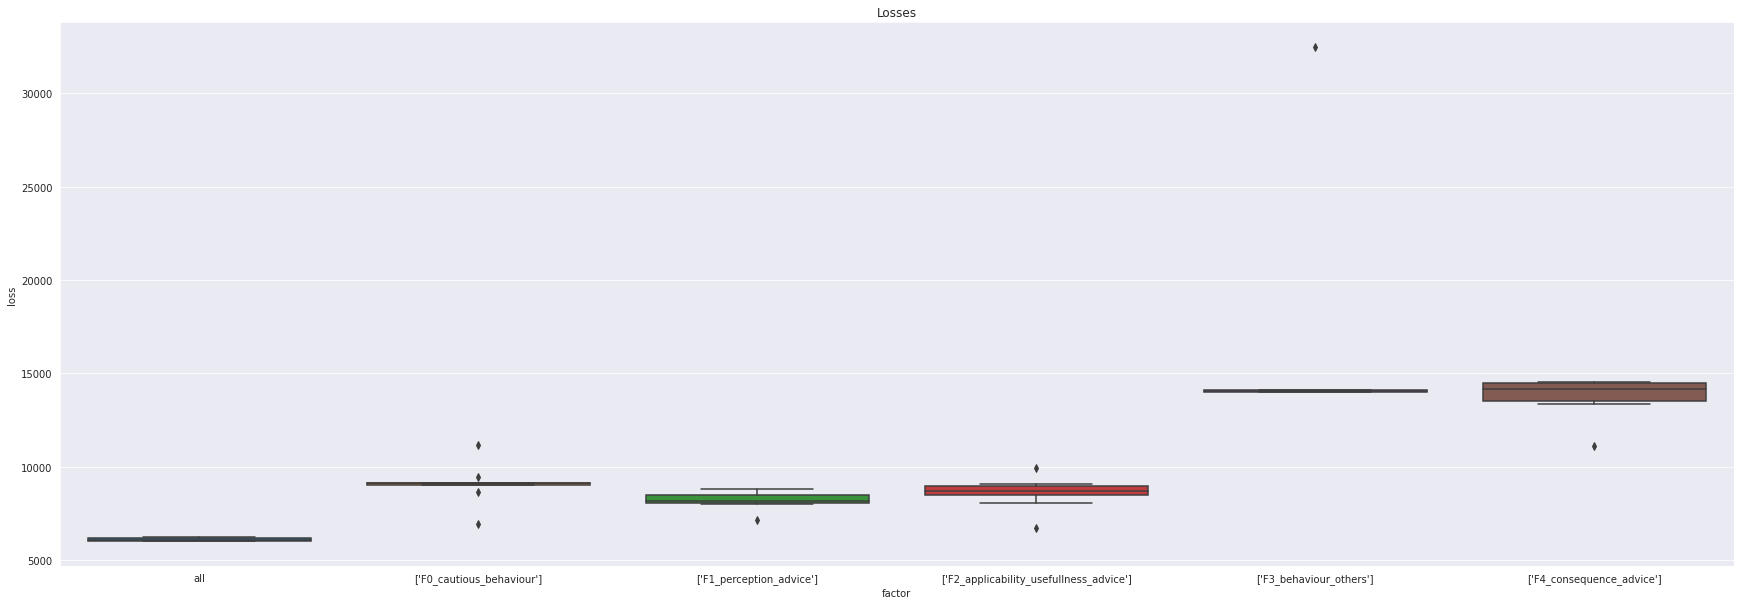

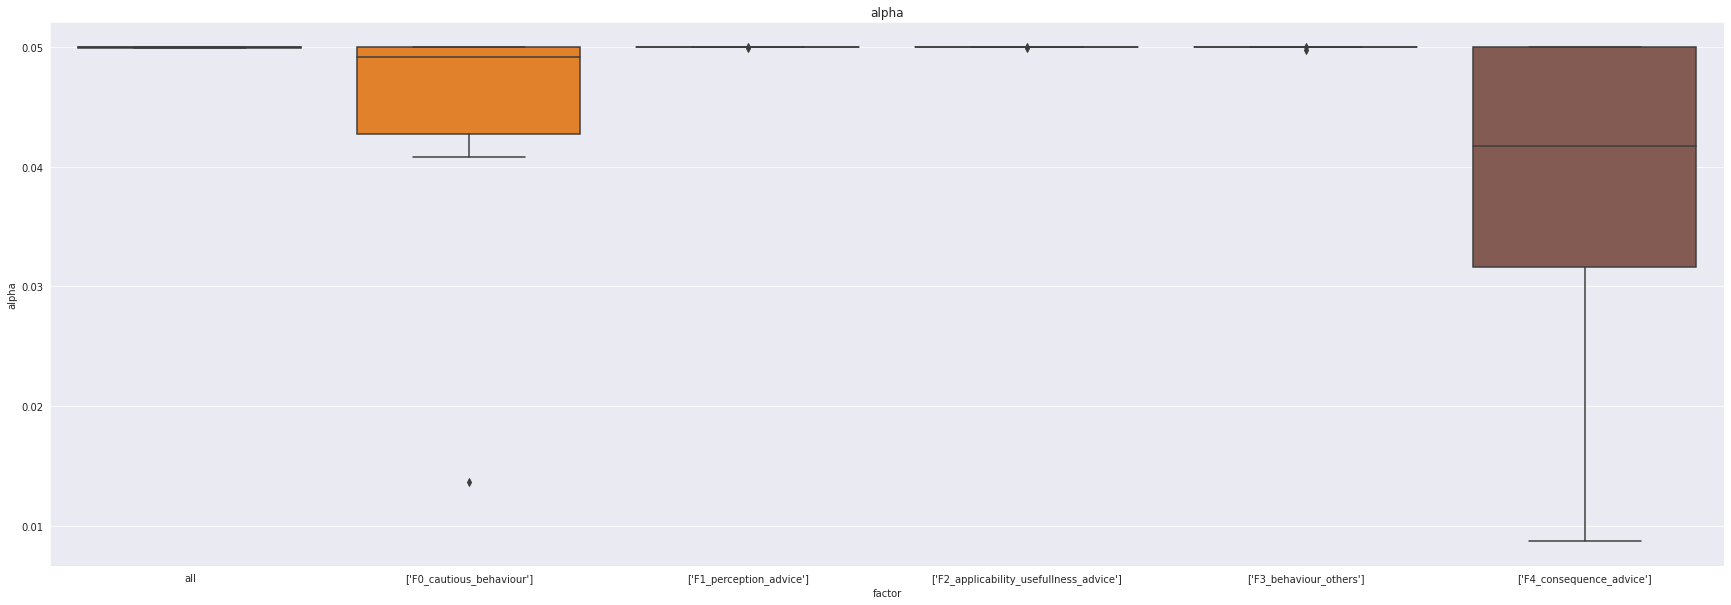

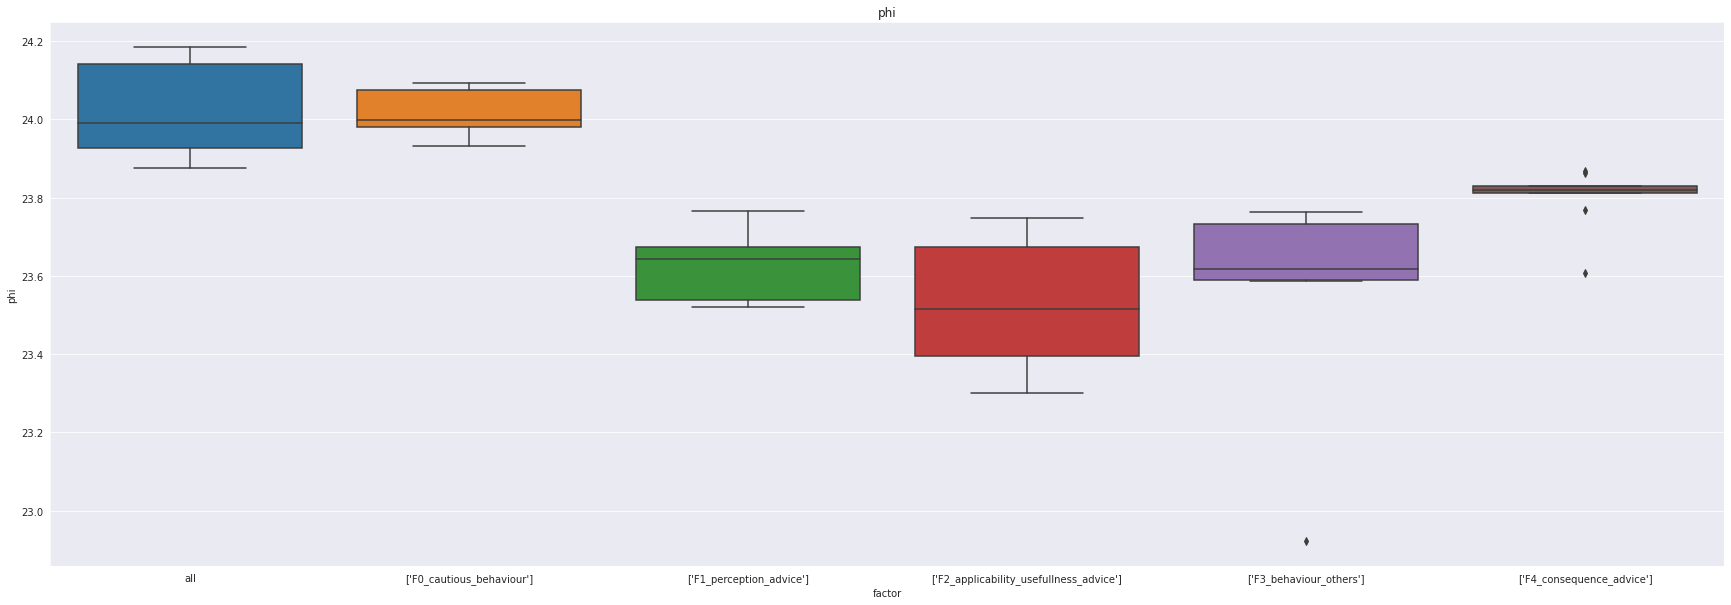

In [12]:
loss_list = []
alpha_list = []
phi_list = []

for factor in factors_info.keys():
    for meta_epoch in factors_info[factor]['loss_development'].keys():
        loss_list.append({'factor':factor, 'meta_epoch':meta_epoch, 'loss':factors_info[factor]['meta_epoch_params'][meta_epoch]['loss'].detach().item()})
        alpha_list.append({'factor':factor, 'meta_epoch':meta_epoch, 'alpha':factors_info[factor]['meta_epoch_params'][meta_epoch]['alpha'].item()})
        phi_list.append({'factor':factor, 'meta_epoch':meta_epoch, 'phi':factors_info[factor]['meta_epoch_params'][meta_epoch]['phi'].item()})

df_loss = pd.DataFrame(loss_list)
df_alpha = pd.DataFrame(alpha_list)
df_phi = pd.DataFrame(phi_list)

df_loss.replace({"['F1_perception_advice', 'F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']": 'all'}, inplace=True)

df_alpha.replace({"['F1_perception_advice', 'F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']": 'all'}, inplace=True)

df_phi.replace({"['F1_perception_advice', 'F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']": 'all'}, inplace=True)

plt.figure(figsize=(30,10))
sns.boxplot(data=df_loss, x="factor", y="loss")
plt.title('Losses')
plt.show()

plt.figure(figsize=(30,10))
sns.boxplot(data=df_alpha, x="factor", y="alpha")
plt.title('alpha')
plt.show()

plt.figure(figsize=(30,10))
sns.boxplot(data=df_phi, x="factor", y="phi")
plt.title('phi')
plt.show()

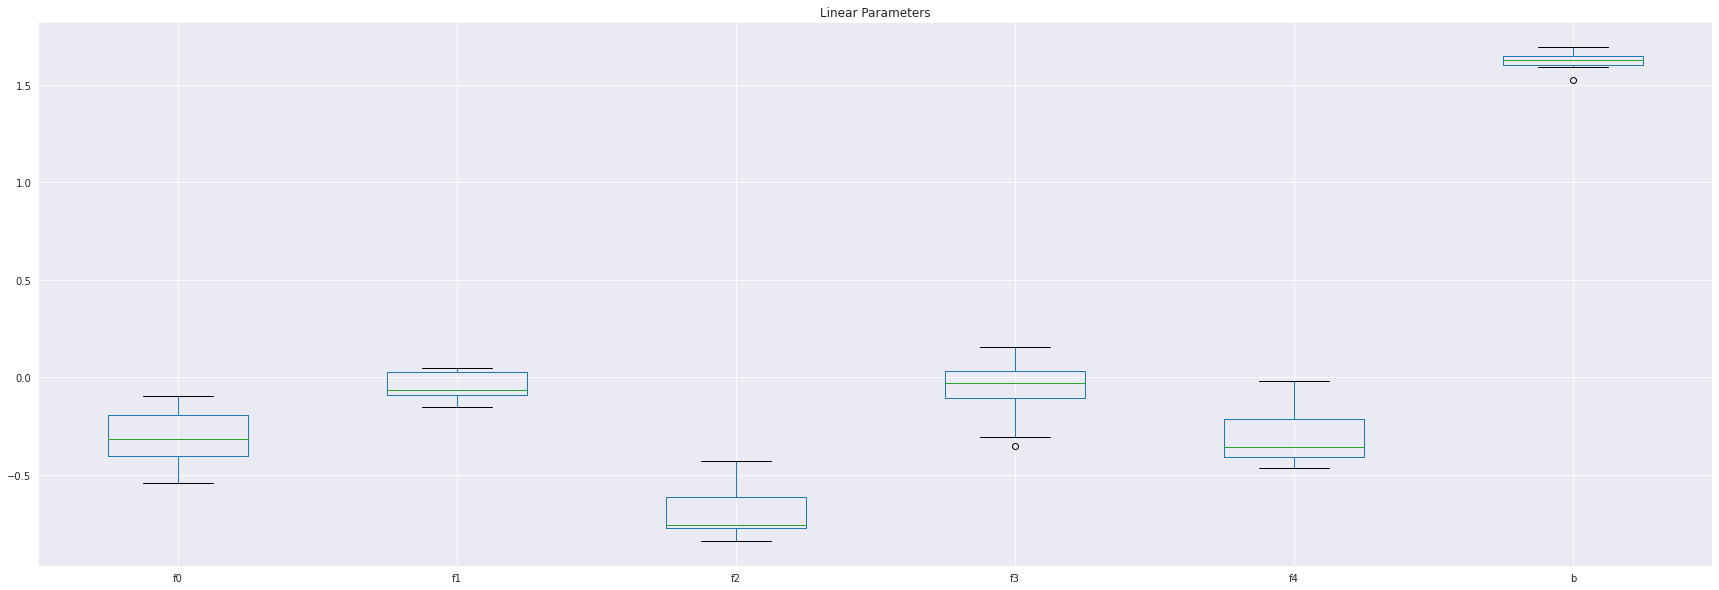

In [59]:
df_factors_all_list = []
for meta_epoch in  factors_info["['F1_perception_advice', 'F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']"]['meta_epoch_params'].keys():

    m = factors_info["['F1_perception_advice', 'F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']"]['meta_epoch_params'][meta_epoch]['lin_params'][0].detach()[0].to('cpu').numpy()

    b = factors_info["['F1_perception_advice', 'F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']"]['meta_epoch_params'][meta_epoch]['lin_params'][1].detach()[0].to('cpu').numpy()

    df_factors_all_list.append({'f0':m[0], 'f1':m[1], 'f2':m[2], 'f3':m[3], 'f4':m[4], 'b':b.item()})
plt.figure(figsize=(30,10))
df_factors_all = pd.DataFrame(df_factors_all_list)
df_factors_all.boxplot()

plt.title('Linear Parameters')
plt.show()

In [55]:
factors_info.keys()

dict_keys(["['F1_perception_advice', 'F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']", "['F0_cautious_behaviour']", "['F1_perception_advice']", "['F2_applicability_usefullness_advice']", "['F3_behaviour_others']", "['F4_consequence_advice']"])

In [53]:
factors_info["['F0_cautious_behaviour']"]['meta_epoch_params'][0]['lin_params'][0].detach()[0].to('cpu').numpy().item()

-1.0567086935043335

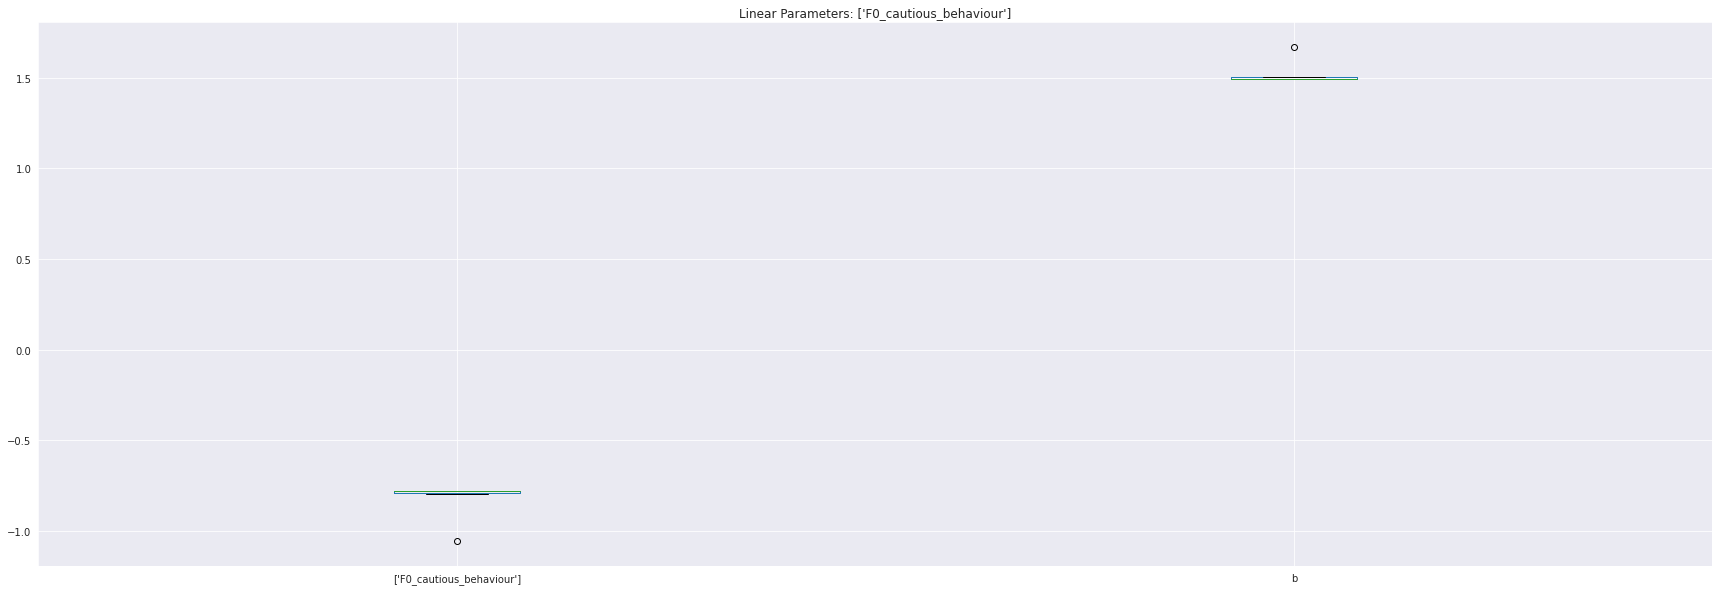

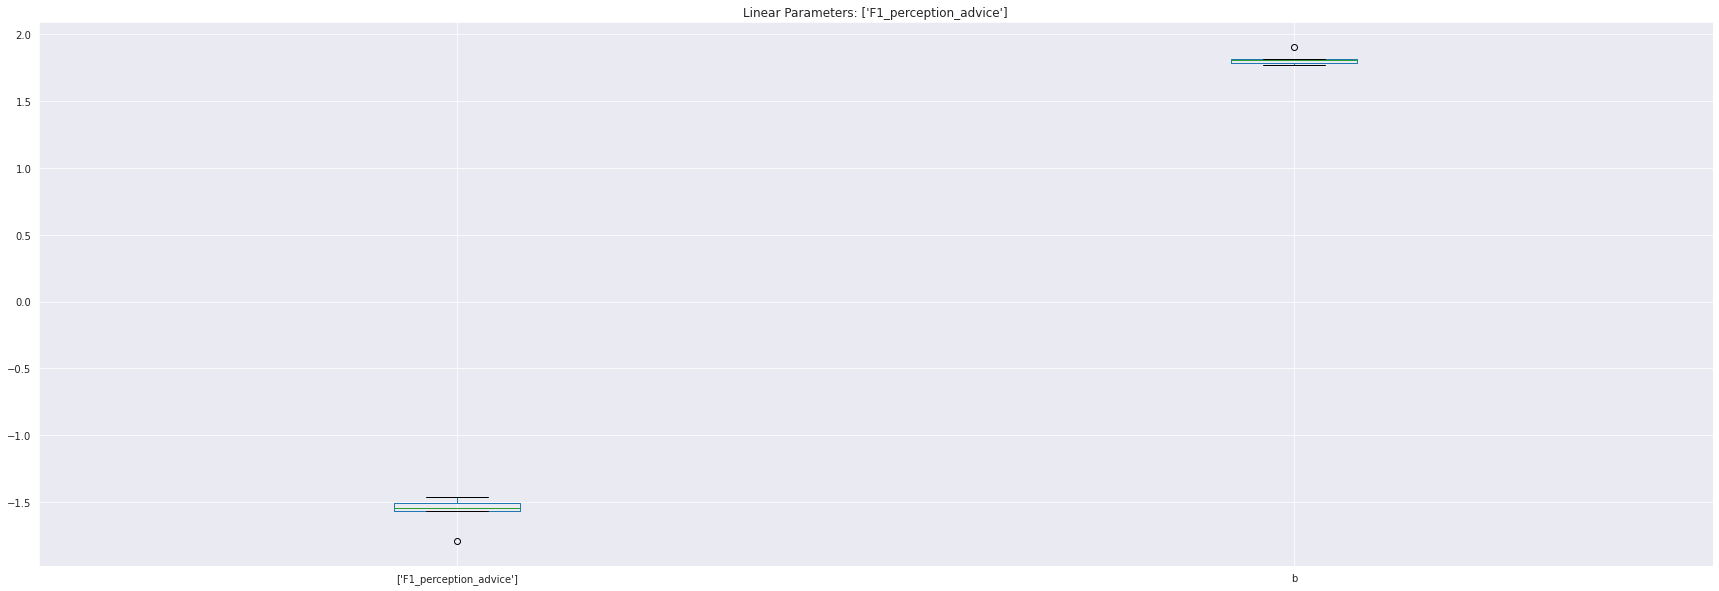

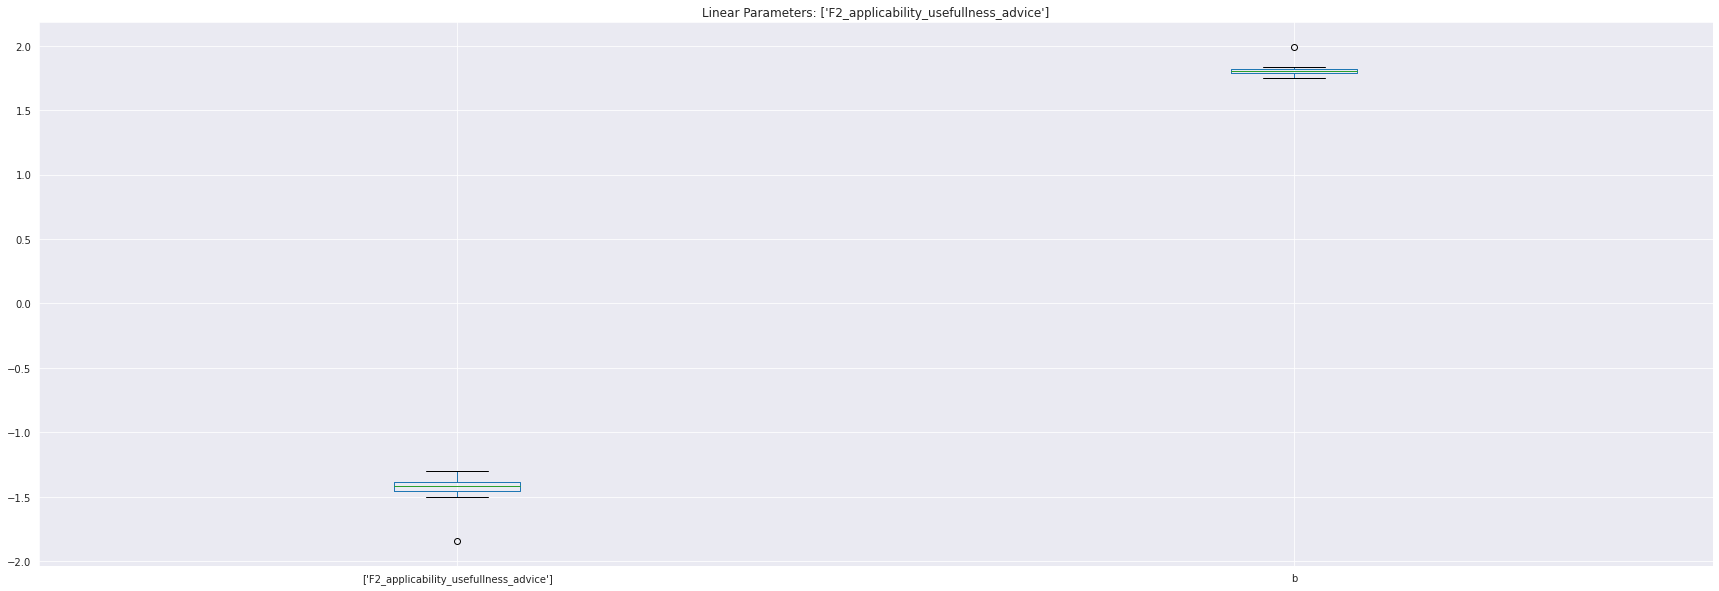

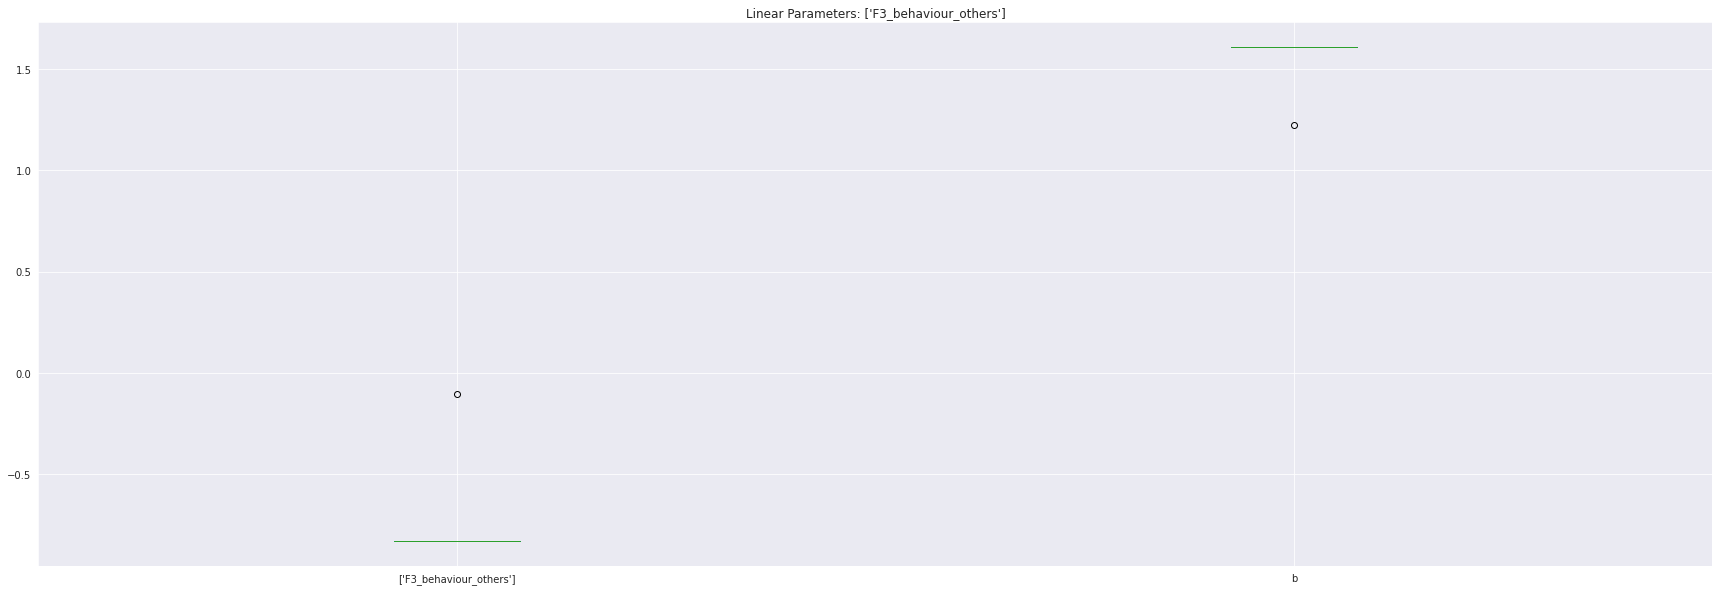

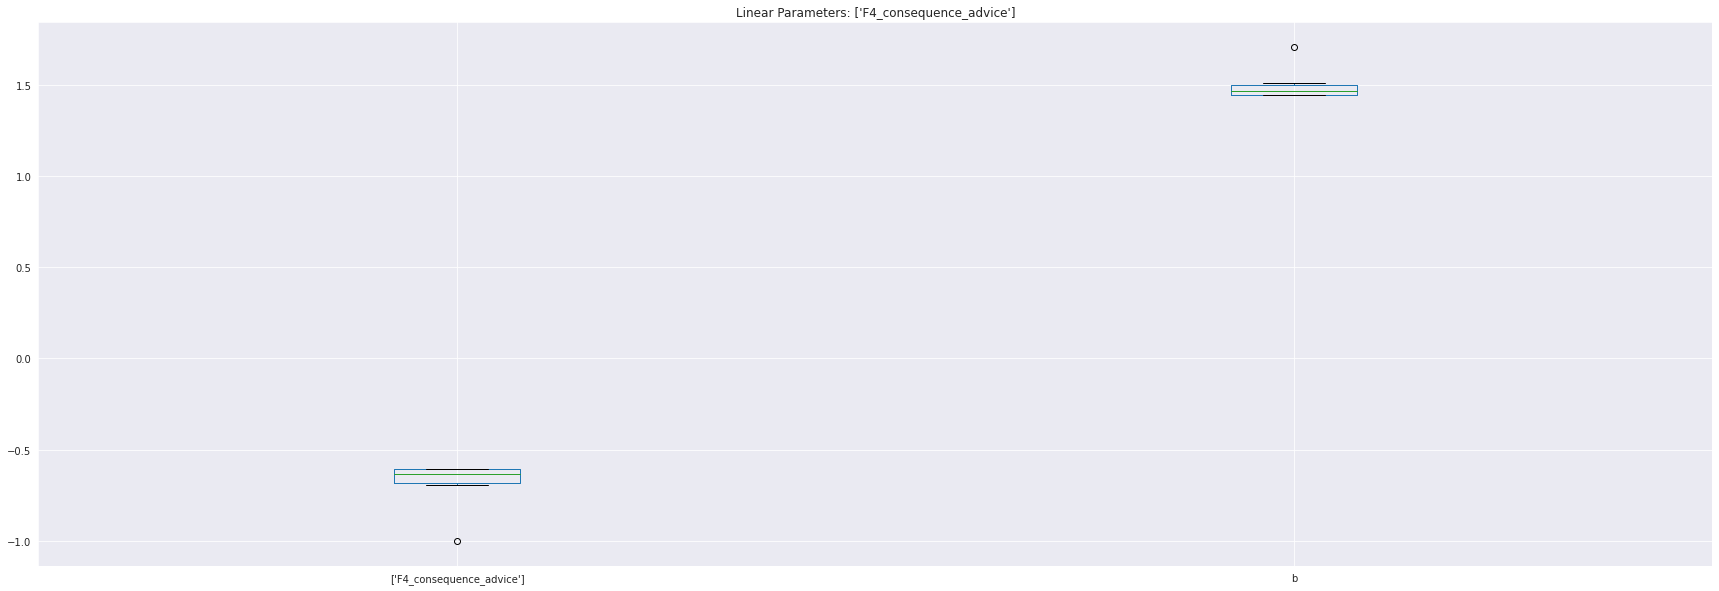

In [60]:

for factor in["['F0_cautious_behaviour']", "['F1_perception_advice']", "['F2_applicability_usefullness_advice']", "['F3_behaviour_others']", "['F4_consequence_advice']"]:
    df_factors_list = []
    for meta_epoch in  factors_info[factor]['meta_epoch_params'].keys():

        m = factors_info[factor]['meta_epoch_params'][meta_epoch]['lin_params'][0].detach()[0].to('cpu').numpy()

        b = factors_info[factor]['meta_epoch_params'][meta_epoch]['lin_params'][1].detach()[0].to('cpu').numpy()

        df_factors_list.append({f'{factor}':m.item(), 'b':b.item()})

    plt.figure(figsize=(30,10))
    df_factors = pd.DataFrame(df_factors_list)
    df_factors.boxplot()
    plt.title(f'Linear Parameters: {factor}')
    plt.show()
